# Conditional Path Execution with lionagi Flow

This notebook demonstrates how to create conditional workflows using the new flow operation.

In [1]:
from lionagi.operations.node import Operation
from lionagi.protocols.graph import Edge, EdgeCondition, Graph
from lionagi.session.session import Session

## Example: Conditional Calculator

Let's create a calculator that:
1. Based on a "case" value, either sums or diffs absolute values
2. Based on the result, either multiplies by 2 (if positive) or adds 2 (if negative)

In [2]:
# Create a session and branch with a system message
session = Session()
calc_branch = session.new_branch(
    system="You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text."
)
session.default_branch = calc_branch

In [3]:
# Create operations for our workflow

# Operation 1a: Sum absolute values (case 0)
sum_op = Operation(
    operation="chat",
    parameters={
        "instruction": "Given context with 'x' and 'y', return the sum of their absolute values: |x| + |y|"
    },
)

# Operation 1b: Diff absolute values (case 1)
diff_op = Operation(
    operation="chat",
    parameters={
        "instruction": "Given context with 'x' and 'y', return the difference of their absolute values: |x| - |y|"
    },
)

# Operation 2: Apply transformation based on sign
transform_op = Operation(
    operation="chat",
    parameters={
        "instruction": """Given the previous result:
        - If the result is positive (> 0), multiply it by 2
        - If the result is zero or negative (≤ 0), add 2 to it
        Return only the numeric result."""
    },
)

## Define Edge Conditions

In [4]:
# Create condition for case-based branching
class CaseCondition(EdgeCondition):
    def __init__(self, expected_case: int):
        super().__init__()
        self.expected_case = expected_case

    async def apply(self, context: dict) -> bool:
        # Check the case value in the context
        case = context.get("context", {}).get("case", None)
        return case == self.expected_case


# Create conditions
case_0_condition = CaseCondition(expected_case=0)
case_1_condition = CaseCondition(expected_case=1)

## Build the Graph

In [5]:
# Create graph
graph = Graph()

# Add nodes
graph.add_node(sum_op)
graph.add_node(diff_op)
graph.add_node(transform_op)

# We need a start node to make the conditional branching work
# In the new design, we can specify starting_node in flow()
# Or we can add a simple start operation
start_op = Operation(
    operation="chat",
    parameters={"instruction": "Acknowledge the input values x and y. Reply 'Ready to calculate.'"},
)
graph.add_node(start_op)

# Add conditional edges
graph.add_edge(Edge(head=start_op.id, tail=sum_op.id, condition=case_0_condition))
graph.add_edge(Edge(head=start_op.id, tail=diff_op.id, condition=case_1_condition))

# Both paths lead to transform
graph.add_edge(Edge(head=sum_op.id, tail=transform_op.id))
graph.add_edge(Edge(head=diff_op.id, tail=transform_op.id))

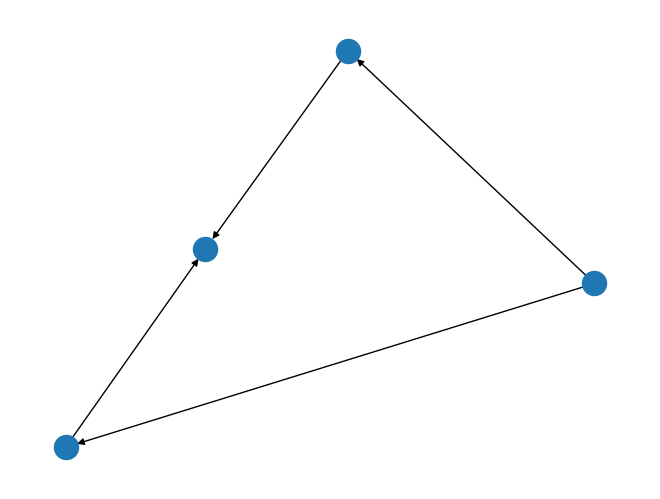

In [6]:
# Visualize the graph
graph.display()

## Execute the Workflow

In [7]:
# Test case 0: Sum absolute values
result_case_0 = await session.flow(
    graph,
    context={"x": -6, "y": 0, "case": 0},
    parallel=True,  # Use parallel execution (now fixed!)
    verbose=True,
)

print("\nCase 0 Results:")
print(f"Completed operations: {result_case_0['completed_operations']}")
print(f"Final result: {result_case_0['operation_results'][transform_op.id]}")

Pre-allocated 3 branches
Executing operation: 98164801
Completed operation: 98164801
Operation 049212a0 waiting for 98164801
Skipping operation due to edge conditions: ad0f8071
Executing operation: 049212a0
Completed operation: 049212a0
Operation 793fa83d waiting for 049212a0
Operation 793fa83d waiting for ad0f8071
Executing operation: 793fa83d
Completed operation: 793fa83d

Case 0 Results:
Completed operations: [IDType(98164801-17dd-47d1-a1fb-c49c8de06c52), IDType(049212a0-883c-4fe2-ac3a-31096ea15931), IDType(793fa83d-1315-46f4-ae62-f01a0f9cddaf)]
Final result: 12


In [8]:
# Test case 1: Diff absolute values
result_case_1 = await session.flow(
    graph,
    context={"x": -6, "y": 0, "case": 1},
    parallel=True,  # Use parallel execution (now fixed!)
    verbose=True,
)

print("\nCase 1 Results:")
print(f"Completed operations: {result_case_1['completed_operations']}")
print(f"Final result: {result_case_1['operation_results'][transform_op.id]}")

Pre-allocated 1 branches
Skipping already completed operation: 049212a0
Skipping already completed operation: 793fa83d
Skipping already completed operation: 98164801
Operation ad0f8071 waiting for 98164801
Executing operation: ad0f8071
Completed operation: ad0f8071

Case 1 Results:
Completed operations: [IDType(049212a0-883c-4fe2-ac3a-31096ea15931), IDType(793fa83d-1315-46f4-ae62-f01a0f9cddaf), IDType(98164801-17dd-47d1-a1fb-c49c8de06c52), IDType(ad0f8071-3ef1-4d1e-b103-0a46f0c033bf)]
Final result: 12


## View Conversation History

In [9]:
# Convert branch messages to DataFrame for easy viewing
df = calc_branch.to_df()
df[["created_at", "role", "content"]]

,created_at,role,content
0,1.757718e+09,system,{'system_message': 'You are asked to perform a...


## Advanced Example: Multi-Step Conditional Logic

In [10]:
# Create a more complex workflow with multiple conditions
# This example demonstrates nested conditions and parallel paths

# Create new session for this example
from typing import Literal

from pydantic import BaseModel

session2 = Session()
branch2 = session2.new_branch(
    system="You are a helpful assistant that processes data step by step."
)
session2.default_branch = branch2


class DataType(BaseModel):
    data_type: Literal["numeric", "text", "mixed"]
    confidence: float


# Create operations
analyze_op = Operation(
    operation="operate",
    parameters={
        "instruction": "Analyze the input data and classify it as 'numeric', 'text', or 'mixed'",
        "response_format": DataType,
    },
)

# Different processing paths based on data type
numeric_process = Operation(
    operation="chat",
    parameters={
        "instruction": "Calculate statistical summary (mean, median, range) of the numeric data"
    },
)

text_process = Operation(
    operation="chat",
    parameters={"instruction": "Provide word count, character count, and identify key themes"},
)

mixed_process = Operation(
    operation="ReAct",
    parameters={
        "instruct": {
            "instruction": "Process both numeric and text components separately, then combine insights"
        },
        "max_extensions": 2,
    },
)

# Final summary
summary_op = Operation(
    operation="chat",
    parameters={"instruction": "Provide a concise summary of all processing results"},
)

# Build graph
complex_graph = Graph()
for op in [
    analyze_op,
    numeric_process,
    text_process,
    mixed_process,
    summary_op,
]:
    complex_graph.add_node(op)


# Define conditions based on analysis results
class DataTypeCondition(EdgeCondition):
    def __init__(self, expected_type: str):
        super().__init__()
        self.expected_type = expected_type

    async def apply(self, context: dict) -> bool:
        # Get the analysis result
        analysis_result = context.get("result", {})
        if isinstance(analysis_result, dict):
            return analysis_result.get("data_type") == self.expected_type
        return False


# Add conditional edges
complex_graph.add_edge(
    Edge(
        head=analyze_op.id,
        tail=numeric_process.id,
        condition=DataTypeCondition("numeric"),
    )
)
complex_graph.add_edge(
    Edge(
        head=analyze_op.id,
        tail=text_process.id,
        condition=DataTypeCondition("text"),
    )
)
complex_graph.add_edge(
    Edge(
        head=analyze_op.id,
        tail=mixed_process.id,
        condition=DataTypeCondition("mixed"),
    )
)

# All paths lead to summary
for process_op in [numeric_process, text_process, mixed_process]:
    complex_graph.add_edge(Edge(head=process_op.id, tail=summary_op.id))

In [11]:
# Test with different data types
test_data = [
    {"data": [1, 2, 3, 4, 5], "description": "numeric data"},
    {
        "data": "The quick brown fox jumps over the lazy dog",
        "description": "text data",
    },
    {
        "data": {"values": [10, 20, 30], "labels": ["A", "B", "C"]},
        "description": "mixed data",
    },
]

for test_case in test_data:
    print(f"\nTesting with {test_case['description']}:")
    result = await session2.flow(
        complex_graph, context={"input_data": test_case["data"]}, verbose=True
    )
    print(f"Summary: {result['operation_results'][summary_op.id]}")


Testing with numeric data:
Pre-allocated 4 branches
Executing operation: edc58e15
Completed operation: edc58e15
Operation 58601ddc waiting for edc58e15
Skipping operation due to edge conditions: 767060a6
Skipping operation due to edge conditions: 82e4b283
Executing operation: 58601ddc
Completed operation: 58601ddc
Operation 33695a26 waiting for 58601ddc
Operation 33695a26 waiting for 767060a6
Operation 33695a26 waiting for 82e4b283
Executing operation: 33695a26
Completed operation: 33695a26
Summary: The statistical summary of the data set {1, 2, 3, 4, 5} is:  
- Mean = 3  
- Median = 3  
- Range = 4

Testing with text data:
Pre-allocated 2 branches
Skipping already completed operation: edc58e15
Skipping already completed operation: 58601ddc
Skipping already completed operation: 33695a26
Skipping operation due to edge conditions: 767060a6
Skipping operation due to edge conditions: 82e4b283
Summary: The statistical summary of the data set {1, 2, 3, 4, 5} is:  
- Mean = 3  
- Median = 3 

## Parallel Execution Example

In [12]:
# Create a workflow that benefits from parallel execution
from lionagi.session import Session

# Create session for multi-branch coordination
session3 = Session()

# Create parallel analysis operations
parallel_ops = [
    Operation(
        operation="chat",
        parameters={"instruction": f"Analyze aspect {i}: {aspect}"},
    )
    for i, aspect in enumerate(
        [
            "Market potential and competitive landscape",
            "Technical feasibility and implementation challenges",
            "Financial requirements and ROI projections",
            "Risk factors and mitigation strategies",
        ]
    )
]


class Recommendation(BaseModel):
    recommendation: Literal["proceed", "reconsider", "reject"]
    confidence: float
    key_insights: list[str]


# Create synthesis operation
synthesis_op = Operation(
    operation="operate",
    parameters={
        "instruction": "Synthesize all analyses into a comprehensive recommendation",
        "response_format": Recommendation,
    },
)

# Build parallel graph
parallel_graph = Graph()

# Add all nodes
for op in parallel_ops:
    parallel_graph.add_node(op)
parallel_graph.add_node(synthesis_op)

# Connect all parallel ops to synthesis (no dependencies between them)
for op in parallel_ops:
    parallel_graph.add_edge(Edge(head=op.id, tail=synthesis_op.id))

# Execute with parallel processing
parallel_result = await session3.flow(
    parallel_graph,
    context={"project": "Launch an AI-powered personal finance app"},
    max_concurrent=4,
    verbose=True,
)

print("\nFinal Recommendation:")
print(parallel_result["operation_results"][synthesis_op.id])

Pre-allocated 1 branches
Executing operation: 1c4bd736
Executing operation: 4e836f0d
Executing operation: e7813153
Executing operation: a43e23f5
Completed operation: 4e836f0d
Completed operation: a43e23f5
Completed operation: 1c4bd736
Operation 26d3cd53 waiting for 1c4bd736
Operation 26d3cd53 waiting for 4e836f0d
Operation 26d3cd53 waiting for e7813153
Completed operation: e7813153
Operation 26d3cd53 waiting for a43e23f5
Executing operation: 26d3cd53
Completed operation: 26d3cd53

Final Recommendation:
recommendation='proceed' confidence=0.85 key_insights=['The market potential for an AI-powered personal finance app is strong, supported by increasing consumer demand for personalized digital finance solutions, especially among tech-savvy Millennials, Gen Z, and underserved segments like freelancers.', 'The competitive landscape is mature with established players, but gaps remain in deep AI integration, hyper-personalization, and targeting of underserved user groups, creating opportuniti